# Plan for the next 3 seminars
* Warm up: decision trees - their strengths and limitations
* Moving slowly to real world - bagging ensembles
* An interlude on uncertainty
* Heavy duty maching learning - gradient boosting machines

# Decision Trees
![Decision tree joke](https://camo.githubusercontent.com/08b9d1f7280425a77ddf445fb40dc1e0827ea44a/68747470733a2f2f7062732e7477696d672e636f6d2f6d656469612f4231336e3256564349414130684a532e6a7067)

// Based on our [course at ICL](https://github.com/yandexdataschool/MLatImperial2019-private/blob/master/04_lab/lab4_trees_ensambling_stacking.ipynb), [MLHEP 2018](https://github.com/yandexdataschool/mlhep2018/blob/master/day1-Mon/seminar-02-tree-ensembles-1-bagging-xgboost-Solution.ipynb), [MLHEP 2019](https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-2/02_decision_trees_and_ensembles.ipynb)

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

Generating a toy dataset with 2 features for binary classification:

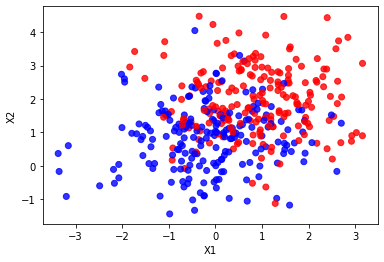

In [2]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
                          centers=[[0., 1.], [1., 2.]],
                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

## Enter Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Key parameters:
* `max_depth` – a limit on tree depth (default – no limit)
* `min_samples_split` – there should be at least this many samples to split further (default – 2)
* `min_samples_leaf` – there should be at least this many samples on one side of a split to consider it valid (default – 1).
* `criterion` – the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.


In [4]:
from sklearn.metrics import accuracy_score
import matplotlib
def plot_decision_surface(clf,
                          X: np.ndarray,
                          y: np.ndarray,
                          grid_step: float=0.02,
                          cmap='bwr',
                          alpha:float=0.6,
                          axes=None
        ):
    """
    Plot the decision surface of a classifier, visualize selected points
    Args:
      clf: a fitted model, must support predict method
      X[n_examples, n_features]: points where to evaluate the classifier
      y[n_examples]: true labels
      grid_step: decision surface plottting grid
      alpha: opacity of the decision surface
      axes(matplotlib.axes._subplots.AxesSubplot): axes where plot, if None, a new figure is created
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    if axes is None:
      _, axes = plt.subplots()
    axes.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    axes.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    axes.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    axes.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    axes.legend(loc='best')

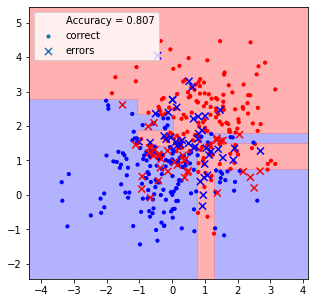

In [15]:
clf = DecisionTreeClassifier(min_samples_leaf=10).fit(X_toy, y_toy)
fig, ax = plt.subplots(figsize=(5, 5))
plot_decision_surface(clf, X_toy, y_toy, axes=ax)

As promissed, trees can be visualized

In [16]:
import sklearn.tree

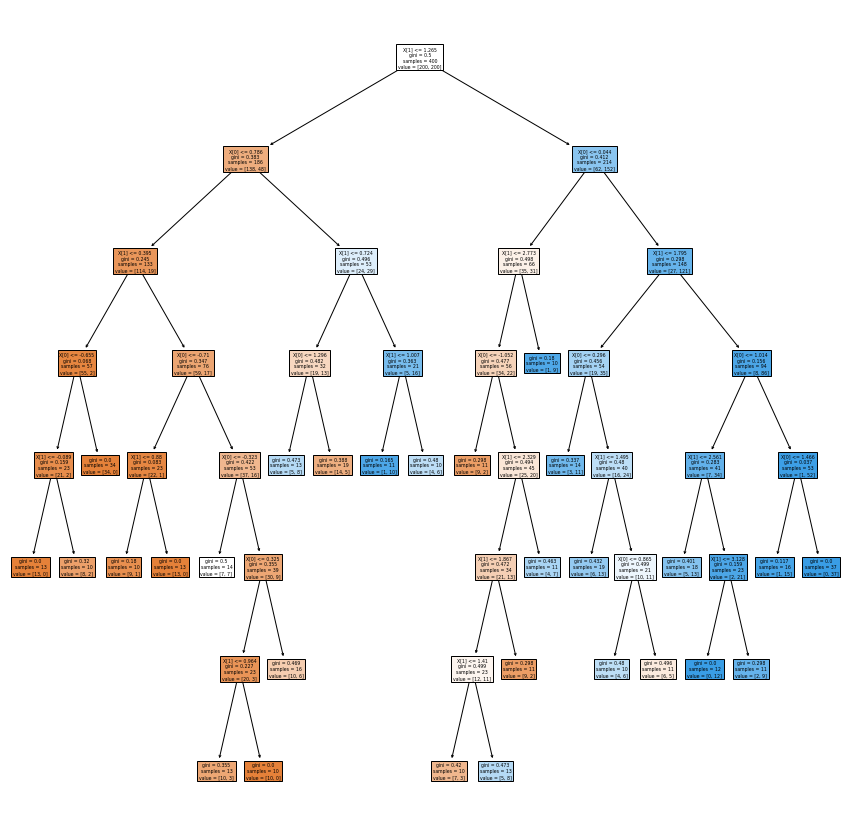

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
sklearn.tree.plot_tree(clf, ax=ax, filled=True);

Let's load the multiclassification toy data and then continue to the tasks

In [11]:
!wget https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz

--2020-07-17 10:46:36--  https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... 

connected.


HTTP request sent, awaiting response... 

302 Found
Location: https://raw.githubusercontent.com/yandexdataschool/mlhep2018/master/day1-Mon/data.npz [following]
--2020-07-17 10:46:36--  https://raw.githubusercontent.com/yandexdataschool/mlhep2018/master/day1-Mon/data.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108474 (106K) [application/octet-stream]
Saving to: ‘data.npz’

data.npz              0%[                    ]       0  --.-KB/s               

data.npz            100%[===================>] 105.93K  --.-KB/s    in 0.02s   

2020-07-17 10:46:37 (5.55 MB/s) - ‘data.npz’ saved [108474/108474]



In [12]:
#DATA_FOLDER = "../../data/1.5.1-decion-trees"
DATA_FOLDER = "."
muticlass_toy_data = np.load(os.path.join(DATA_FOLDER, "data.npz"))
# The data should be in CoCalc. If it isn't, we are soory for that, it can be downloaded here:
# https://github.com/yandexdataschool/mlhep2018/raw/master/day1-Mon/data.npz

In [18]:
X_toy_multiclass_train, X_toy_multiclass_test, \
  y_toy_multiclass_train, y_toy_multiclass_test = \
    train_test_split(muticlass_toy_data["X"], muticlass_toy_data["y"],
                     test_size=0.5, random_state=4)
X_toy_train, X_toy_test, y_toy_train, y_toy_test = \
    train_test_split(X_toy, y_toy, test_size=0.25, random_state=42)

### Task 1 (difficulty: easy)
Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the `max_depth` parameter. Try out the following values: ``[1, 2, 3, 5, 10]``. Make decision boundary plots for both train and test datasets (separately).

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7fbbbaa0b588>>
Traceback (most recent call last):
  File "/home/user/.local/lib/python3.6/site-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/home/user/.local/lib/python3.6/site-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


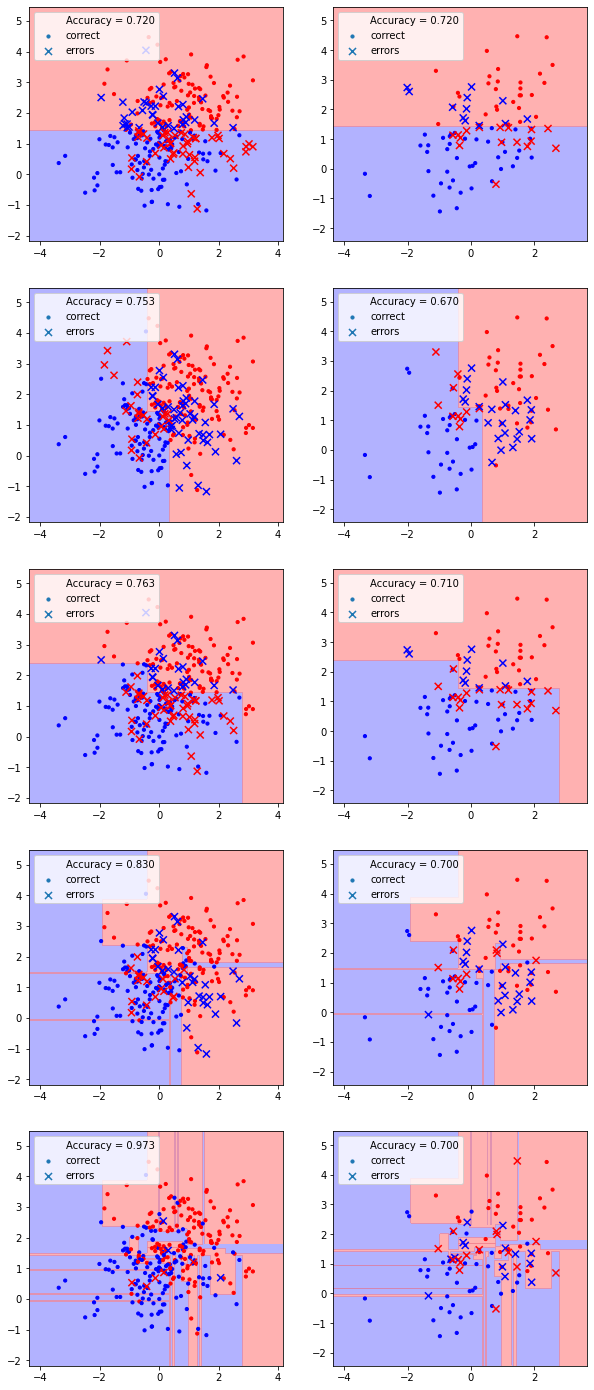

In [20]:
depth_values = [1, 2, 3, 5, 10]

fig, axes_matrix = plt.subplots(nrows=len(depth_values), ncols=2,
                                figsize=(2*5, 5*len(depth_values)))
for depth, (axes_train, axes_test) in zip(depth_values, axes_matrix):
    # The boilerplate code is the elegant way to get a grid of plots in matplotlib
    # All you need is to fit a decision tree and call plot_decision_surface
    # axes_train and axes_test for train and test plots correspondingly
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_toy_train, y_toy_train)
    plot_decision_surface(clf, X_toy_train, y_toy_train, axes=axes_train)
    plot_decision_surface(clf, X_toy_test, y_toy_test, axes=axes_test)

### Task 2 (difficulty: moderate)
We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy for the multiclassification problem.

    Accuracy >= 0.72 - not bad for a start
    Accuracy >= 0.75 - better, but not enough
    Accuracy >= 0.77 - pretty good
    Accuracy >= 0.78 - great! (probably the best result for a single tree)

Feel free to modify the DecisionTreeClassifier below instead of re-writing everything.

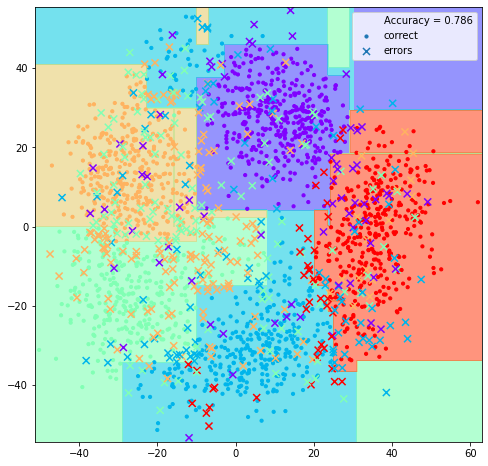

In [28]:
# Train a classifer
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_toy_multiclass_train, y_toy_multiclass_train)

# Plot the decision surface on the test data
# Note the accuracy number in top-right corner
fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(clf, X_toy_multiclass_test, y_toy_multiclass_test, cmap='rainbow', grid_step=0.2, axes=ax);

In [27]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_toy_multiclass_train, y_toy_multiclass_train)

DecisionTreeClassifier()

In [29]:
test_accuracy = accuracy_score(clf.predict(X_toy_multiclass_test), y_toy_multiclass_test)
test_accuracy

0.7856191744340879

## Decision trees conclusion
Key advantages:
* Interpretable results
* Not sensitive to data scaling
* Natural support for missing values and categorial data

Key disadvanatages:
* (comparatively) poor quality of the result
* Unstable training - small variations in the data might result in a completely different tree being generated